In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Prediction performance evaluation

In [2]:
df = pd.read_csv('../datafiles/chexpert/chexpert.sample.test.csv')

white = 'White'
asian = 'Asian'
black = 'Black'

## Race classification

In [3]:
data_dir = '../prediction/chexpert/race/densenet-all/'
cnn_pred_race = pd.read_csv(data_dir + 'predictions.test.csv')

In [4]:
preds_race = np.stack([cnn_pred_race['class_0'],cnn_pred_race['class_1'],cnn_pred_race['class_2']]).transpose()
targets_race = np.array(cnn_pred_race['target'])
preds_race_labels = np.argmax(preds_race, axis=1)

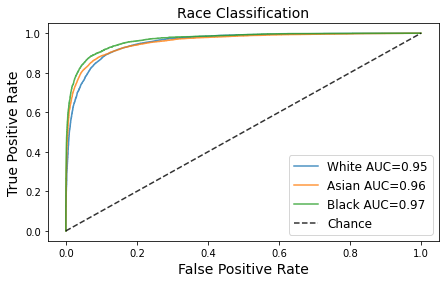

In [5]:
# WHITE
pos_label = 0
y = np.array(targets_race)
y[targets_race != pos_label] = 0
y[targets_race == pos_label] = 1
fpr_w, tpr_w, _ = roc_curve(y, preds_race[:,pos_label])
roc_auc_w = auc(fpr_w, tpr_w)

# ASIAN
pos_label = 1
y = np.array(targets_race)
y[targets_race != pos_label] = 0
y[targets_race == pos_label] = 1
fpr_a, tpr_a, _ = roc_curve(y, preds_race[:,pos_label])
roc_auc_a = auc(fpr_a, tpr_a)

# BLACK
pos_label = 2
y = np.array(targets_race)
y[targets_race != pos_label] = 0
y[targets_race == pos_label] = 1
fpr_b, tpr_b, _ = roc_curve(y, preds_race[:,pos_label])
roc_auc_b = auc(fpr_b, tpr_b)

fig, ax = plt.subplots(figsize=(7,4))
plt.plot(fpr_w, tpr_w, lw=1.5, alpha=.8, label='White AUC=%0.2f' % roc_auc_w)
plt.plot(fpr_a, tpr_a, lw=1.5, alpha=.8, label='Asian AUC=%0.2f' % roc_auc_a)
plt.plot(fpr_b, tpr_b, lw=1.5, alpha=.8, label='Black AUC=%0.2f' % roc_auc_b)
ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.title('Race Classification', fontsize=14)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
plt.show()

# fig.savefig("CNN-race.png", bbox_inches='tight', dpi=300)

## Sex classification

In [6]:
data_dir = '../prediction/chexpert/sex/densenet-all/'
cnn_pred_sex = pd.read_csv(data_dir + 'predictions.test.csv')

# for subgroup analysis
# cnn_pred_sex['race'] = df['race']
# cnn_pred_sex = cnn_pred_sex[cnn_pred_sex['race'] == white]
# cnn_pred_sex = cnn_pred_sex[cnn_pred_sex['race'] == asian]
# cnn_pred_sex = cnn_pred_sex[cnn_pred_sex['race'] == black]

In [7]:
preds_sex = np.stack([cnn_pred_sex['class_0'],cnn_pred_sex['class_1']]).transpose()
targets_sex = np.array(cnn_pred_sex['target'])
preds_sex_labels = np.argmax(preds_sex, axis=1)

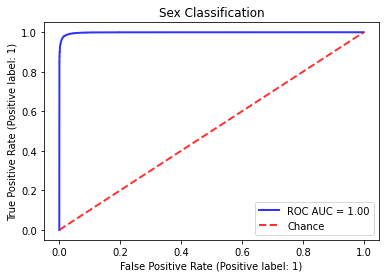

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     22266
           1       0.99      0.97      0.98     15974

    accuracy                           0.98     38240
   macro avg       0.98      0.98      0.98     38240
weighted avg       0.98      0.98      0.98     38240



In [8]:
fpr, tpr, _ = roc_curve(targets_sex, preds_sex[:,1])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='b', lw=2, alpha=.8, label='ROC AUC = %0.2f' % roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate (Positive label: 1)')
plt.ylabel('True Positive Rate (Positive label: 1)')
plt.legend(loc="lower right")
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Sex Classification")
plt.show()
# fig.savefig("CheXpert-CNN-sex.png", bbox_inches='tight', dpi=300)

report = classification_report(targets_sex,preds_sex_labels)
print(report)

## Disease classification (multi-label)

In [9]:
labels = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices']

In [10]:
label = 0    # No finding
# label = 10 # Pleural effusion
print(labels[label])

No Finding


In [11]:
data_dir = '../prediction/chexpert/disease/densenet-all/'
cnn_pred = pd.read_csv(data_dir + 'predictions.test.csv')

cnn_pred['race'] = df['race']
cnn_pred['sex'] = df['sex']
cnn_pred['age'] = df['age']
cnn_pred[labels[label]] = df[labels[label]]
cnn_pred['race_pred'] = preds_race_labels
cnn_pred['sex_pred'] = preds_sex_labels

# subgroups
cnn_pred_m = cnn_pred[cnn_pred['sex'] == 'Male'].copy()
cnn_pred_f = cnn_pred[cnn_pred['sex'] == 'Female'].copy()
cnn_pred_w = cnn_pred[cnn_pred['race'] == white].copy()
cnn_pred_a = cnn_pred[cnn_pred['race'] == asian].copy()
cnn_pred_b = cnn_pred[cnn_pred['race'] == black].copy()

In [12]:
preds = cnn_pred['class_' + str(label)]
targets = np.array(cnn_pred['target_' + str(label)])

preds_m = cnn_pred_m['class_' + str(label)]
targets_m = np.array(cnn_pred_m['target_' + str(label)])

preds_f = cnn_pred_f['class_' + str(label)]
targets_f = np.array(cnn_pred_f['target_' + str(label)])

preds_w = cnn_pred_w['class_' + str(label)]
targets_w = np.array(cnn_pred_w['target_' + str(label)])

preds_a = cnn_pred_a['class_' + str(label)]
targets_a = np.array(cnn_pred_a['target_' + str(label)])

preds_b = cnn_pred_b['class_' + str(label)]
targets_b = np.array(cnn_pred_b['target_' + str(label)])

In [13]:
target_fpr = 0.2

fpr, tpr, thres = roc_curve(targets, preds)
fpr_w, tpr_w, thres_w = roc_curve(targets_w, preds_w)
fpr_a, tpr_a, thres_a = roc_curve(targets_a, preds_a)
fpr_b, tpr_b, thres_b = roc_curve(targets_b, preds_b)
fpr_m, tpr_m, thres_m = roc_curve(targets_m, preds_m)
fpr_f, tpr_f, thres_f = roc_curve(targets_f, preds_f)

roc_auc = auc(fpr, tpr)
roc_auc_w = auc(fpr_w, tpr_w)
roc_auc_a = auc(fpr_a, tpr_a)
roc_auc_b = auc(fpr_b, tpr_b)
roc_auc_m = auc(fpr_m, tpr_m)
roc_auc_f = auc(fpr_f, tpr_f)

# global threshold
op = thres[np.argmin(np.abs(fpr-target_fpr))]

# group-specific thresholds
op_race = np.zeros(3)
op_race[0] = thres_w[np.argmin(np.abs(fpr_w-target_fpr))]
op_race[1] = thres_a[np.argmin(np.abs(fpr_a-target_fpr))]
op_race[2] = thres_b[np.argmin(np.abs(fpr_b-target_fpr))]

op_sex = np.zeros(2)
op_sex[0] = thres_m[np.argmin(np.abs(fpr_m-target_fpr))]
op_sex[1] = thres_f[np.argmin(np.abs(fpr_f-target_fpr))]

# determine thresholds based on sex and race classification outputs
cnn_pred_w['race_op'] = cnn_pred_w['race_pred']
cnn_pred_w.loc[cnn_pred_w['race_op'] == 0, 'race_op'] = op_race[0]
cnn_pred_w.loc[cnn_pred_w['race_op'] == 1, 'race_op'] = op_race[1]
cnn_pred_w.loc[cnn_pred_w['race_op'] == 2, 'race_op'] = op_race[2]

cnn_pred_a['race_op'] = cnn_pred_a['race_pred']
cnn_pred_a.loc[cnn_pred_a['race_op'] == 0, 'race_op'] = op_race[0]
cnn_pred_a.loc[cnn_pred_a['race_op'] == 1, 'race_op'] = op_race[1]
cnn_pred_a.loc[cnn_pred_a['race_op'] == 2, 'race_op'] = op_race[2]

cnn_pred_b['race_op'] = cnn_pred_b['race_pred']
cnn_pred_b.loc[cnn_pred_b['race_op'] == 0, 'race_op'] = op_race[0]
cnn_pred_b.loc[cnn_pred_b['race_op'] == 1, 'race_op'] = op_race[1]
cnn_pred_b.loc[cnn_pred_b['race_op'] == 2, 'race_op'] = op_race[2]

cnn_pred_m['sex_op'] = cnn_pred_m['sex_pred']
cnn_pred_m.loc[cnn_pred_m['sex_op'] == 0, 'sex_op'] = op_sex[0]
cnn_pred_m.loc[cnn_pred_m['sex_op'] == 1, 'sex_op'] = op_sex[1]

cnn_pred_f['sex_op'] = cnn_pred_f['sex_pred']
cnn_pred_f.loc[cnn_pred_f['sex_op'] == 0, 'sex_op'] = op_sex[0]
cnn_pred_f.loc[cnn_pred_f['sex_op'] == 1, 'sex_op'] = op_sex[1]

print('All \t Threshold %0.4f' % op)
print('White \t Threshold %0.4f' % op_race[0])
print('Asian \t Threshold %0.4f' % op_race[1])
print('Black \t Threshold %0.4f' % op_race[2])
print('Female \t Threshold %0.4f' % op_sex[1])
print('Male \t Threshold %0.4f' % op_sex[0])

All 	 Threshold 0.1036
White 	 Threshold 0.1026
Asian 	 Threshold 0.1000
Black 	 Threshold 0.1183
Female 	 Threshold 0.1044
Male 	 Threshold 0.1028


In [14]:
# APPLYING GLOBAL THRESHOLD
fpr_t = 1 - recall_score(targets, preds>=op, pos_label=0)
tpr_t = recall_score(targets, preds>=op, pos_label=1)

fpr_t_w = 1 - recall_score(targets_w, preds_w>=op, pos_label=0)
tpr_t_w = recall_score(targets_w, preds_w>=op, pos_label=1)

fpr_t_a = 1 - recall_score(targets_a, preds_a>=op, pos_label=0)
tpr_t_a = recall_score(targets_a, preds_a>=op, pos_label=1)

fpr_t_b = 1 - recall_score(targets_b, preds_b>=op, pos_label=0)
tpr_t_b = recall_score(targets_b, preds_b>=op, pos_label=1)

fpr_t_f = 1 - recall_score(targets_f, preds_f>=op, pos_label=0)
tpr_t_f = recall_score(targets_f, preds_f>=op, pos_label=1)

fpr_t_m = 1 - recall_score(targets_m, preds_m>=op, pos_label=0)
tpr_t_m = recall_score(targets_m, preds_m>=op, pos_label=1)

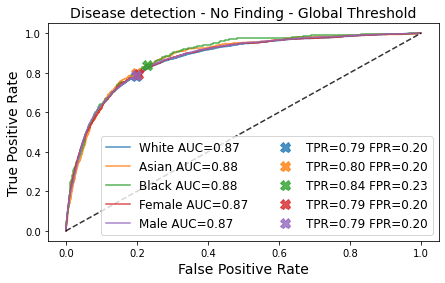

All	TPR 0.79 | FPR 0.20 | AUC 0.87
White	TPR 0.79 | FPR 0.20 | AUC 0.87
Asian	TPR 0.80 | FPR 0.20 | AUC 0.88
Black	TPR 0.84 | FPR 0.23 | AUC 0.88
Female	TPR 0.79 | FPR 0.20 | AUC 0.87
Male	TPR 0.79 | FPR 0.20 | AUC 0.87


In [15]:
fig, ax = plt.subplots(figsize=(7,4))
plt.plot(fpr_w, tpr_w, lw=1.5, alpha=.8, label='White AUC=%0.2f' % roc_auc_w)
plt.plot(fpr_a, tpr_a, lw=1.5, alpha=.8, label='Asian AUC=%0.2f' % roc_auc_a)
plt.plot(fpr_b, tpr_b, lw=1.5, alpha=.8, label='Black AUC=%0.2f' % roc_auc_b)
plt.plot(fpr_f, tpr_f, lw=1.5, alpha=.8, label='Female AUC=%0.2f' % roc_auc_f)
plt.plot(fpr_m, tpr_m, lw=1.5, alpha=.8, label='Male AUC=%0.2f' % roc_auc_m)

plt.gca().set_prop_cycle(None)

plt.plot(fpr_t_w, tpr_t_w, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_t_w,fpr_t_w))
plt.plot(fpr_t_a, tpr_t_a, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_t_a,fpr_t_a))
plt.plot(fpr_t_b, tpr_t_b, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_t_b,fpr_t_b))
plt.plot(fpr_t_f, tpr_t_f, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_t_f,fpr_t_f))
plt.plot(fpr_t_m, tpr_t_m, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_t_m,fpr_t_m))

plt.legend(loc="lower right", fontsize=12, ncol=2)

ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Disease detection - ' + labels[label] + ' - Global Threshold', fontsize=14)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
plt.show()
# fig.savefig("CheXpert-CNN-disease-global-threshold.png", bbox_inches='tight', dpi=300)

print('All\tTPR %0.2f | FPR %0.2f | AUC %0.2f' % (tpr_t,fpr_t,roc_auc))
print('White\tTPR %0.2f | FPR %0.2f | AUC %0.2f' % (tpr_t_w,fpr_t_w,roc_auc_w))
print('Asian\tTPR %0.2f | FPR %0.2f | AUC %0.2f' % (tpr_t_a,fpr_t_a,roc_auc_a))
print('Black\tTPR %0.2f | FPR %0.2f | AUC %0.2f' % (tpr_t_b,fpr_t_b,roc_auc_b))
print('Female\tTPR %0.2f | FPR %0.2f | AUC %0.2f' % (tpr_t_f,fpr_t_f,roc_auc_f))
print('Male\tTPR %0.2f | FPR %0.2f | AUC %0.2f' % (tpr_t_m,fpr_t_m,roc_auc_m))

In [16]:
# APPLYING GROUP-SPECIFC THRESHOLDS
fpr_t = 1 - recall_score(targets, preds>=op, pos_label=0)
tpr_t = recall_score(targets, preds>=op, pos_label=1)

fpr_t_w = 1 - recall_score(targets_w, preds_w>=cnn_pred_w['race_op'], pos_label=0)
tpr_t_w = recall_score(targets_w, preds_w>=cnn_pred_w['race_op'], pos_label=1)

fpr_t_a = 1 - recall_score(targets_a, preds_a>=cnn_pred_a['race_op'], pos_label=0)
tpr_t_a = recall_score(targets_a, preds_a>=cnn_pred_a['race_op'], pos_label=1)

fpr_t_b = 1 - recall_score(targets_b, preds_b>=cnn_pred_b['race_op'], pos_label=0)
tpr_t_b = recall_score(targets_b, preds_b>=cnn_pred_b['race_op'], pos_label=1)

fpr_t_f = 1 - recall_score(targets_f, preds_f>=cnn_pred_f['sex_op'], pos_label=0)
tpr_t_f = recall_score(targets_f, preds_f>=cnn_pred_f['sex_op'], pos_label=1)

fpr_t_m = 1 - recall_score(targets_m, preds_m>=cnn_pred_m['sex_op'], pos_label=0)
tpr_t_m = recall_score(targets_m, preds_m>=cnn_pred_m['sex_op'], pos_label=1)

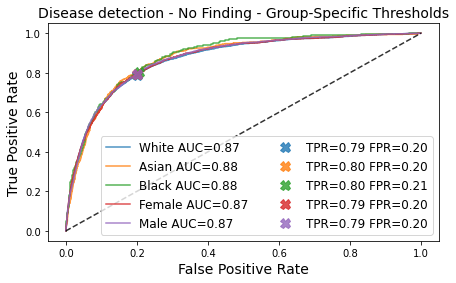

All	TPR 0.79 | FPR 0.20 | AUC 0.87
White	TPR 0.79 | FPR 0.20 | AUC 0.87
Asian	TPR 0.80 | FPR 0.20 | AUC 0.88
Black	TPR 0.80 | FPR 0.21 | AUC 0.88
Female	TPR 0.79 | FPR 0.20 | AUC 0.87
Male	TPR 0.79 | FPR 0.20 | AUC 0.87


In [17]:
fig, ax = plt.subplots(figsize=(7,4))
plt.plot(fpr_w, tpr_w, lw=1.5, alpha=.8, label='White AUC=%0.2f' % roc_auc_w)
plt.plot(fpr_a, tpr_a, lw=1.5, alpha=.8, label='Asian AUC=%0.2f' % roc_auc_a)
plt.plot(fpr_b, tpr_b, lw=1.5, alpha=.8, label='Black AUC=%0.2f' % roc_auc_b)
plt.plot(fpr_f, tpr_f, lw=1.5, alpha=.8, label='Female AUC=%0.2f' % roc_auc_f)
plt.plot(fpr_m, tpr_m, lw=1.5, alpha=.8, label='Male AUC=%0.2f' % roc_auc_m)

plt.gca().set_prop_cycle(None)

plt.plot(fpr_t_w, tpr_t_w, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_t_w,fpr_t_w))
plt.plot(fpr_t_a, tpr_t_a, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_t_a,fpr_t_a))
plt.plot(fpr_t_b, tpr_t_b, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_t_b,fpr_t_b))
plt.plot(fpr_t_f, tpr_t_f, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_t_f,fpr_t_f))
plt.plot(fpr_t_m, tpr_t_m, 'X', alpha=.8, markersize=10, label='TPR=%0.2f FPR=%0.2f' % (tpr_t_m,fpr_t_m))

plt.legend(loc="lower right", fontsize=12, ncol=2)

ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Disease detection - ' + labels[label] + ' - Group-Specific Thresholds', fontsize=14)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
plt.show()
# fig.savefig("CheXpert-CNN-disease-group-specific-threshold.png", bbox_inches='tight', dpi=300)

print('All\tTPR %0.2f | FPR %0.2f | AUC %0.2f' % (tpr_t,fpr_t,roc_auc))
print('White\tTPR %0.2f | FPR %0.2f | AUC %0.2f' % (tpr_t_w,fpr_t_w,roc_auc_w))
print('Asian\tTPR %0.2f | FPR %0.2f | AUC %0.2f' % (tpr_t_a,fpr_t_a,roc_auc_a))
print('Black\tTPR %0.2f | FPR %0.2f | AUC %0.2f' % (tpr_t_b,fpr_t_b,roc_auc_b))
print('Female\tTPR %0.2f | FPR %0.2f | AUC %0.2f' % (tpr_t_f,fpr_t_f,roc_auc_f))
print('Male\tTPR %0.2f | FPR %0.2f | AUC %0.2f' % (tpr_t_m,fpr_t_m,roc_auc_m))